In [74]:
import torch
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from pathlib import Path

In [75]:
# Check what physical devices are available
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Cuda is available! Training on GPU.")
elif torch.backends.mps.is_available():
    print("No Cuda available, checking for mps.")
    device = torch.device("mps")
    print("MPS is available! Training on Apple Silicon GPU.")
else:
    print("MPS is not available. Training on CPU.")
    device = torch.device("cpu")

No Cuda available, checking for mps.
MPS is available! Training on Apple Silicon GPU.


## Load and prepare the data

In [76]:
life_expectancy_data = pd.read_csv(Path("./data/life_expectancy_who.csv"))

In [77]:
def create_feature_and_target_data(life_expectancy_data: pd.DataFrame) -> (np.array, np.array):
    """Create feature and target TensorFlow tensors from life expectancy data.

    Args:
        dataframe: Life expectancy data downloaded from Kaggle kumarajarshi/life-expectancy-who.

    Returns:
        X, y the features and target data.
    """
    # Rename columns to remove spaces and make lowercase
    life_expectancy_data.columns = [column.lower().strip().replace(" ", "_") for column in life_expectancy_data.columns]

    # Extract specific columns from dataframe
    feature_columns = [
        "alcohol",
        "bmi",
        "polio",
        "total_expenditure",
        "diphtheria",
        "hiv/aids",
        "gdp",
        "population",
        "income_composition_of_resources",
        "schooling",
    ]
    target_column = "life_expectancy"
    columns = [*feature_columns, target_column]

    processed_dataframe = (
        life_expectancy_data.filter(columns)  # Filter columns
        .dropna(axis=0)  # Remove rows with NaN values
        .assign(gdp_per_capita=lambda df: df["gdp"] / df["population"])  # Create new column dividing gdp by population
        .drop(columns=["gdp", "population"])  # Drop gdp and population columns
    )

    # Create features and target data
    X = processed_dataframe.drop(columns=[target_column]).to_numpy()
    y = processed_dataframe[target_column].to_numpy()

    return X, y

In [78]:
X, y = create_feature_and_target_data(life_expectancy_data)
X.shape, y.shape

((2094, 9), (2094,))

In [79]:
# Split train-test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Standardize data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert to TensorFlow constant tensors
X_train, y_train = torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32)
X_test, y_test = torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32)

## Linear regression model

We will fit a simple model of the form

$$
y = h_\theta(\mathbf{x}) + \epsilon,

$$

where $y\in\mathbb{R}$ is the target variable, $\mathbf{x}\in\mathbb{R}^{9}$ are the input features, $\theta\in\mathbb{R}^{10}$ are the model parameters, $\epsilon\sim\mathcal{N}(0, 1)$ is the observation noise random variable, and $f_\theta:\mathbb{R}^{9}\mapsto\mathbb{R}$ is given by

$$
\begin{align}
h_\theta(\mathbf{x}) &= \theta_0 + \sum_{m=1}^{9} \theta_m x_m\\
&= \sum_{m=0}^{10} \theta_m x_m.
\end{align}
$$

In the second line above we have defined $x_0=1$ to be the constant feature. 

### MLE Normal Equations

The maximum likelihood solution is given by the normal equation

$$
\theta_{ML} = \left(\mathbf{X}^T \mathbf{X}\right)^{-1}\mathbf{X}^T\mathbf{y},
$$

where $\mathbf{X}\in\mathbb{R}^{N\times M}$ is the data matrix, $\mathbf{y}\in\mathbb{R}^N$ are the targets, $N$ is the number of data examples, and $M$ are the number of features (including the constant feature).

In [80]:
def normal_equation_tf(X: torch.Tensor, y: torch.Tensor) -> torch.Tensor:
    """Calculate parameters using normal equations.

    Args:
        X: Features tensor
        y: Target tensor
    """
    ones = torch.ones([X.shape[0], 1], dtype=X.dtype)
    X_bias = torch.concat([ones, X], axis=1)
    X_bias_T = torch.transpose(X_bias, dim0=0, dim1=1)
    XTX = torch.matmul(X_bias_T, X_bias)
    inv_XTX = torch.linalg.inv(XTX)
    inv_XTX_XT = torch.matmul(inv_XTX, X_bias_T)

    return torch.matmul(inv_XTX_XT, y)

In [81]:
normal_equation_tf(X_train, y_train)

tensor([68.7835, -0.4168,  1.2120,  0.3541,  0.1934,  0.5038, -3.7782,  2.4875,
         3.7791,  0.2814])

## Gradient Descent

We define the loss function as the Mean Squared Error

$$ J(\theta)=\frac{1}{n}\sum_{i=1}^{n}(h_{\theta}(\mathbb{x^{(i)}})-y^{(i)})^2$$

Our goal is to minimise $J_\theta$ with respect to $\theta$

$$\underset{\theta}{\text{minimise }}J(\theta)$$


The update step of Gradient Descent is
$$
\theta_{m, t+1} = \theta_{m, t} - \eta \nabla_\theta {L}_{MSE}(\theta_{m, t})
$$

where $\eta>0$ is the learning rate and $t$ is the iteration.

In [82]:
def calc_y_pred(bias: torch.Tensor, weights: torch.Tensor, X: torch.Tensor) -> torch.Tensor:
    """Calculate y_pred using Linear Regression.

    Args:
        bias: The bias term in the Linear Regression equation.
        weights: The weights in the Linear Regression equation.
        X: The features tensor.

    Returns:
        The predicted values.
    """
    return bias + torch.matmul(X, weights)

In [83]:
# given
bias = torch.Tensor([1.0])
weights = torch.Tensor([2.0, 3.0])
inputs = torch.Tensor([[1.0, 2.0], [3.0, 4.0]])

# when
result = calc_y_pred(bias, weights, inputs).numpy()

# then
expected = np.array([9.0, 19.0])
assert (result == expected).all()

In [84]:
def calc_mse(y_actuals: torch.Tensor, y_pred: torch.Tensor) -> torch.Tensor:
    """Calculate_mean_squared_error.

    Args:
        y_pred: The predicted values.
        y_actuals: The actual values.

    Returns:
        The mean squared error.
    """
    return torch.mean(torch.square(y_actuals - y_pred))

In [85]:
# given
preds = torch.Tensor([1.0, 1.0, 1.0, 1.0])
actuals = torch.Tensor([1.0, 1.0, 11.0, 1.0])

# when
result = calc_mse(actuals, preds).numpy()

# then
expected = 25.0
assert result == expected

In [86]:
def update_parameters(
    bias: torch.Tensor, weights: torch.Tensor, X_train: torch.Tensor, y_train: torch.Tensor, learning_rate: float
):
    """Update parameters using Gradient Descent.

    Args:
        bias: The bias term in the Linear Regression equation.
        weights: The weights in the Linear Regression equation.
        X_train: The input training data.
        y_train: The actual target values for training.
        learning_rate: The learning rate for Gradient Descent.
    """
    bias.requires_grad_(True)
    weights.requires_grad_(True)

    # Calculate the current predictions
    y_pred = calc_y_pred(bias, weights, X_train)

    # Calculate the loss (mean squared error)
    loss = calc_mse(y_train, y_pred)

    # Compute the gradients of loss with respect to bias and weights
    loss.backward()

    with torch.no_grad():
        # Update bias and weights using Gradient Descent
        bias -= learning_rate * bias.grad
        weights -= learning_rate * weights.grad

        # Reset gradients to zero
        bias.grad.zero_()
        weights.grad.zero_()

In [87]:
def gradient_descent(
    n_iterations: int,
    X_train: torch.Tensor,
    y_train: torch.Tensor,
    bias: torch.Tensor,
    weights: torch.Tensor,
):
    """Perform Gradient Descent to find optimal parameters of a Linear Regression.

    Args:
        n_iterations: The number of gradient descent iterations.
        X_train: The input training data.
        y_train: The actual target values for training.
        iteration: A variable to track the current iteration.
        bias: Randomly initialised bias term of the model.
        weights: Randomly initialised weights of the model.

    Returns:
        List of Mean Squared Error for each iteration.
    """
    learning_rate = 0.01
    losses = []

    for i in range(1, n_iterations + 1):
        update_parameters(bias, weights, X_train, y_train, learning_rate)
        y_pred = calc_y_pred(bias, weights, X_train)
        loss = calc_mse(y_train, y_pred)
        losses.append(loss.item())
        if i % 100 == 0:
            print(f"Iteration: {i}, Loss: {loss.item()}")

    print("Training completed!")

    return losses

In [88]:
bias_grad_desc = torch.Tensor([0.0])
weights_grad_desc = torch.randn([9])
iteration = 0

In [89]:
losses = gradient_descent(
    n_iterations=2000,
    X_train=X_train,
    y_train=y_train,
    bias=bias_grad_desc,
    weights=weights_grad_desc,
)

Iteration: 100, Loss: 102.39413452148438
Iteration: 200, Loss: 19.907981872558594
Iteration: 300, Loss: 18.384485244750977
Iteration: 400, Loss: 18.3431453704834
Iteration: 500, Loss: 18.339365005493164
Iteration: 600, Loss: 18.3386287689209
Iteration: 700, Loss: 18.338457107543945
Iteration: 800, Loss: 18.338409423828125
Iteration: 900, Loss: 18.338394165039062
Iteration: 1000, Loss: 18.33838653564453
Iteration: 1100, Loss: 18.33838653564453
Iteration: 1200, Loss: 18.3383846282959
Iteration: 1300, Loss: 18.3383846282959
Iteration: 1400, Loss: 18.3383846282959
Iteration: 1500, Loss: 18.3383846282959
Iteration: 1600, Loss: 18.3383846282959
Iteration: 1700, Loss: 18.3383846282959
Iteration: 1800, Loss: 18.3383846282959
Iteration: 1900, Loss: 18.3383846282959
Iteration: 2000, Loss: 18.338382720947266
Training completed!


### Check if loss converges

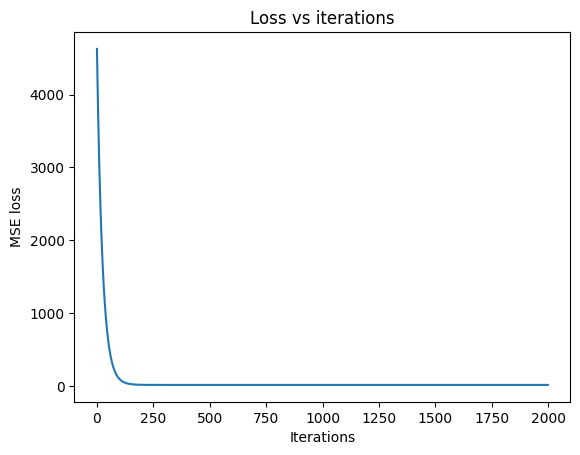

In [90]:
plt.plot(losses)
plt.title("Loss vs iterations")
plt.xlabel("Iterations")
plt.ylabel("MSE loss")
plt.show()

## Compare Normal Equations Parameters to Gradient Descent Parameters

In [91]:
comparison = pd.DataFrame(
    {
        "normal_equation_parameters": normal_equation_tf(X_train, y_train),
        "gradient_descent_parameters": np.hstack([bias_grad_desc.item(), weights_grad_desc.detach().numpy()]),
    }
).assign(difference=lambda df: df["normal_equation_parameters"] - df["gradient_descent_parameters"])

comparison.round(4)

,normal_equation_parameters,gradient_descent_parameters,difference
0,68.783501,68.7833,0.0002
1,-0.416800,-0.4168,-0.0000
2,1.212000,1.2120,-0.0000
3,0.354100,0.3541,-0.0000
4,0.193400,0.1934,-0.0000
5,0.503800,0.5038,0.0000
6,-3.778200,-3.7782,-0.0000
7,2.487500,2.4876,-0.0001
8,3.779100,3.7789,0.0001
9,0.281400,0.2814,-0.0000
